<a href="https://colab.research.google.com/github/mohameddhameem/Learning-and-Planning-in-Intelligent-Systems/blob/main/Question_2_RL_DQN_REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 57.6 MB/s eta 0:00:00


In [2]:
!pip install -q "gymnasium[box2d]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
from collections import deque
import random
import json
import os
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

In [14]:
GLOBAL_CONFIG = {
    'env_name': 'LunarLander-v3',
    'max_episode_steps': 1000,
    'num_seeds': 3,
    'seeds': [42, 123, 456],
    'total_steps': 20_000, # 500_000
    'eval_frequency': 10_000,
    'eval_episodes': 10,
    'gamma': 0.99,
    'log_frequency': 1000,
    'moving_avg_window': 100,
    'save_checkpoint': True,
}

DQN_CONFIG = {
    'hidden_layers': [128, 128],
    'activation': 'relu',
    'learning_rate': 5e-4,
    'batch_size': 64,
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay_steps': 50_000,
    'buffer_capacity': 100_000,
    'min_buffer_size': 1_000,
    'prefill_steps': 1_000,
    'target_update_frequency': 1000,
    'use_soft_update': True,
    'tau': 0.005,
    'optimizer': 'Adam',
    'gradient_clip': 10.0,
    'gamma': 0.99,
}

REINFORCE_CONFIG = {
    'hidden_layers': [128, 128],
    'activation': 'relu',
    'learning_rate': 3e-3,
    'use_baseline': True,
    'baseline_learning_rate': 1e-3,
    'optimizer': 'Adam',
    'gradient_clip': 1.0,
    'normalize_returns': True,
    'gamma': 0.99,
}

In [15]:
def set_seed(seed: int):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


def create_env(seed: int):
    env = gym.make(GLOBAL_CONFIG['env_name'])
    # Apply a TimeLimit wrapper when max_episode_steps is specified in GLOBAL_CONFIG
    if GLOBAL_CONFIG.get('max_episode_steps'):
        env = gym.wrappers.TimeLimit(env, max_episode_steps=GLOBAL_CONFIG['max_episode_steps'])
    env.reset(seed=seed)
    try:
        env.action_space.seed(seed)
    except Exception:
        pass
    return env


def check_gpu():
    """Check GPU availability and print info."""
    if torch.cuda.is_available():
        device_name = torch.cuda.get_device_name(0)
        print(f"GPU Available: {device_name}")
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    else:
        print("⚠ No GPU detected - using CPU (will be slower)")
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
class QNetwork(nn.Module):
    """Deep Q-Network for value function approximation."""

    def __init__(self, state_dim=8, action_dim=4, hidden_layers=[128, 128]):
        super().__init__()
        layers = []
        input_dim = state_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim

        layers.append(nn.Linear(input_dim, action_dim))
        self.network = nn.Sequential(*layers)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
            nn.init.constant_(module.bias, 0)

    def forward(self, state):
        return self.network(state)


class PolicyNetwork(nn.Module):
    """Stochastic policy network for REINFORCE."""

    def __init__(self, state_dim=8, action_dim=4, hidden_layers=[128, 128]):
        super().__init__()
        layers = []
        input_dim = state_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim

        self.feature_network = nn.Sequential(*layers)
        self.action_head = nn.Linear(input_dim, action_dim)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight, gain=np.sqrt(2))
            nn.init.constant_(module.bias, 0)

    def forward(self, state):
        features = self.feature_network(state)
        logits = self.action_head(features)
        action_probs = F.softmax(logits, dim=-1)
        return action_probs

    def get_action(self, state):
        """Sample action from policy."""
        probs = self.forward(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob


class ValueNetwork(nn.Module):
    """Baseline value network for variance reduction."""

    def __init__(self, state_dim=8, hidden_layers=[128, 128]):
        super().__init__()
        layers = []
        input_dim = state_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim

        layers.append(nn.Linear(input_dim, 1))
        self.network = nn.Sequential(*layers)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight, gain=1.0)
            nn.init.constant_(module.bias, 0)

    def forward(self, state):
        return self.network(state).squeeze(-1)

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, capacity=100_000):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)

        states = np.array([e[0] for e in batch], dtype=np.float32)
        actions = np.array([e[1] for e in batch], dtype=np.int64)
        rewards = np.array([e[2] for e in batch], dtype=np.float32)
        next_states = np.array([e[3] for e in batch], dtype=np.float32)
        dones = np.array([e[4] for e in batch], dtype=np.float32)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

In [17]:
class DQNAgent:
    """Deep Q-Network with target network and experience replay."""

    def __init__(self, state_dim, action_dim, config, device=None):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.config = config

        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        # Networks
        self.q_network = QNetwork(state_dim, action_dim, config['hidden_layers']).to(self.device)
        self.target_network = QNetwork(state_dim, action_dim, config['hidden_layers']).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=config['learning_rate'])

        # Replay buffer
        self.replay_buffer = ReplayBuffer(config['buffer_capacity'])

        # Exploration
        self.epsilon = config['epsilon_start']
        self.epsilon_decay = (config['epsilon_start'] - config['epsilon_end']) / max(1, config['epsilon_decay_steps'])

        # Tracking
        self.steps = 0
        self.episodes = 0

    def select_action(self, state, evaluation=False):
        if evaluation or np.random.random() > self.epsilon:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.q_network(state_tensor)
                action = q_values.argmax(dim=1).item()
        else:
            action = np.random.randint(self.action_dim)

        return action

    def update(self):
        if len(self.replay_buffer) < self.config['min_buffer_size']:
            return None

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.config['batch_size'])

        states = torch.FloatTensor(states).to(self.device, non_blocking=True)
        actions = torch.LongTensor(actions).to(self.device, non_blocking=True)
        rewards = torch.FloatTensor(rewards).to(self.device, non_blocking=True)
        next_states = torch.FloatTensor(next_states).to(self.device, non_blocking=True)
        dones = torch.FloatTensor(dones).to(self.device, non_blocking=True)

        current_q = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q = self.target_network(next_states).max(dim=1)[0]
            target_q = rewards + (1 - dones) * self.config['gamma'] * next_q

        loss = nn.functional.smooth_l1_loss(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q_network.parameters(), self.config['gradient_clip'])
        self.optimizer.step()

        if self.config['use_soft_update']:
            self._soft_update_target()
        elif self.steps % self.config['target_update_frequency'] == 0:
            self._hard_update_target()

        self.epsilon = max(self.config['epsilon_end'], self.epsilon - self.epsilon_decay)

        return loss.item()

    def _soft_update_target(self):
        tau = self.config['tau']
        for target_param, param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def _hard_update_target(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
        self.steps += 1

In [18]:
class REINFORCEAgent:
    """REINFORCE with reward-to-go and optional baseline."""

    def __init__(self, state_dim, action_dim, config, device=None):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.config = config

        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        # Policy and (optional) value network
        self.policy = PolicyNetwork(state_dim, action_dim, config['hidden_layers']).to(self.device)
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=config['learning_rate'])

        if config.get('use_baseline'):
            self.value_net = ValueNetwork(state_dim, config['hidden_layers']).to(self.device)
            self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=config['baseline_learning_rate'])
        else:
            self.value_net = None

        self.reset_episode()
        self.steps = 0
        self.episodes = 0

    def reset_episode(self):
        self.episode_states = []
        self.episode_actions = []
        self.episode_log_probs = []
        self.episode_rewards = []

    def select_action(self, state, evaluation=False):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        if evaluation:
            with torch.no_grad():
                probs = self.policy(state_tensor)
                action = probs.argmax(dim=1).item()
            return action
        else:
            action, log_prob = self.policy.get_action(state_tensor)
            return action, log_prob

    def store_transition(self, state, action, log_prob, reward):
        self.episode_states.append(state)
        self.episode_actions.append(action)
        self.episode_log_probs.append(log_prob)
        self.episode_rewards.append(reward)
        self.steps += 1

    def _compute_returns(self):
        returns = []
        G = 0
        gamma = self.config['gamma']
        for reward in reversed(self.episode_rewards):
            G = reward + gamma * G
            returns.insert(0, G)
        return returns

    def update(self):
        if len(self.episode_rewards) == 0:
            return None

        returns = self._compute_returns()

        states = torch.FloatTensor(np.array(self.episode_states)).to(self.device, non_blocking=True)
        log_probs = torch.stack(self.episode_log_probs)
        returns = torch.FloatTensor(returns).to(self.device, non_blocking=True)

        if self.config.get('normalize_returns') and len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        if self.value_net is not None:
            with torch.no_grad():
                values = self.value_net(states)
            advantages = returns - values

            value_loss = nn.functional.mse_loss(self.value_net(states), returns)
            self.value_optimizer.zero_grad()
            value_loss.backward()
            nn.utils.clip_grad_norm_(self.value_net.parameters(), self.config['gradient_clip'])
            self.value_optimizer.step()
        else:
            advantages = returns

        policy_loss = -(log_probs * advantages).mean()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        nn.utils.clip_grad_norm_(self.policy.parameters(), self.config['gradient_clip'])
        self.policy_optimizer.step()

        loss = policy_loss.item()
        self.reset_episode()
        self.episodes += 1
        return loss

In [19]:
def plot_learning_curves(dqn_results, reinforce_results, window=100):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # DQN
    ax = axes[0]
    for result in dqn_results:
        steps = result['episode_steps']
        returns = result['episode_returns']
        if len(returns) == 0:
            continue
        smoothed = uniform_filter1d(returns, size=min(window, len(returns)))
        ax.plot(steps, smoothed, alpha=0.7, label=f"Seed {result['seed']}")

    ax.set_xlabel('Environment Steps', fontsize=12)
    ax.set_ylabel('Episode Return (Moving Avg)', fontsize=12)
    ax.set_title('DQN Learning Curve', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=200, color='r', linestyle='--', linewidth=2, label='Solved (200)')

    # REINFORCE
    ax = axes[1]
    for result in reinforce_results:
        steps = result['episode_steps']
        returns = result['episode_returns']
        if len(returns) == 0:
            continue
        smoothed = uniform_filter1d(returns, size=min(window, len(returns)))
        ax.plot(steps, smoothed, alpha=0.7, label=f"Seed {result['seed']}")

    ax.set_xlabel('Environment Steps', fontsize=12)
    ax.set_ylabel('Episode Return (Moving Avg)', fontsize=12)
    ax.set_title('REINFORCE Learning Curve', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=200, color='r', linestyle='--', linewidth=2, label='Solved (200)')

    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    print("✓ Learning curves saved to 'learning_curves.png'")
    plt.show()


def compute_statistics(results, threshold=200):
    final_returns = []
    steps_to_threshold = []

    for result in results:
        returns = result['episode_returns']
        steps = result['episode_steps']

        if len(returns) == 0:
            continue  # Skip empty results

        # Final performance
        final_window = min(100, len(returns))
        final_returns.append(np.mean(returns[-final_window:]))

        # Steps to threshold
        if len(returns) >= 100:
            smoothed = uniform_filter1d(returns, size=100)
            threshold_indices = np.where(smoothed >= threshold)[0]
            if len(threshold_indices) > 0:
                steps_to_threshold.append(steps[threshold_indices[0]])
            else:
                steps_to_threshold.append(None)
        else:
            steps_to_threshold.append(None)

    valid_steps = [s for s in steps_to_threshold if s is not None]

    stats = {
        'final_return_mean': np.mean(final_returns) if final_returns else 0.0,
        'final_return_std': np.std(final_returns) if final_returns else 0.0,
        'steps_to_threshold_mean': np.mean(valid_steps) if valid_steps else float('inf'),
        'steps_to_threshold_std': np.std(valid_steps) if len(valid_steps) > 1 else 0.0,
        'solved_seeds': len(valid_steps),
        'total_seeds': len(results)
    }
    return stats


def generate_report(dqn_results, reinforce_results):
    dqn_stats = compute_statistics(dqn_results)
    reinforce_stats = compute_statistics(reinforce_results)

    # Format steps with proper handling of inf
    dqn_steps_str = f"{dqn_stats['steps_to_threshold_mean']:.0f}" if dqn_stats['steps_to_threshold_mean'] != float('inf') else "N/A (not reached)"
    dqn_steps_std_str = f" ± {dqn_stats['steps_to_threshold_std']:.0f}" if dqn_stats['steps_to_threshold_std'] > 0 else ""

    reinforce_steps_str = f"{reinforce_stats['steps_to_threshold_mean']:.0f}" if reinforce_stats['steps_to_threshold_mean'] != float('inf') else "N/A (not reached)"
    reinforce_steps_std_str = f" ± {reinforce_stats['steps_to_threshold_std']:.0f}" if reinforce_stats['steps_to_threshold_std'] > 0 else ""

    # Determine winner for sample efficiency
    if dqn_stats['steps_to_threshold_mean'] == float('inf') and reinforce_stats['steps_to_threshold_mean'] == float('inf'):
        efficiency_winner = "Neither (both didn't reach threshold)"
    elif dqn_stats['steps_to_threshold_mean'] == float('inf'):
        efficiency_winner = "REINFORCE"
    elif reinforce_stats['steps_to_threshold_mean'] == float('inf'):
        efficiency_winner = "DQN"
    else:
        efficiency_winner = 'DQN' if dqn_stats['steps_to_threshold_mean'] < reinforce_stats['steps_to_threshold_mean'] else 'REINFORCE'

    report = f"""
{'='*60}
COMPARISON REPORT: DQN vs REINFORCE
{'='*60}

1. FINAL PERFORMANCE (last 100 episodes)
{'-'*60}
DQN:
  Mean Return: {dqn_stats['final_return_mean']:.2f} ± {dqn_stats['final_return_std']:.2f}
  Seeds Solved: {dqn_stats['solved_seeds']}/{dqn_stats['total_seeds']}

REINFORCE:
  Mean Return: {reinforce_stats['final_return_mean']:.2f} ± {reinforce_stats['final_return_std']:.2f}
  Seeds Solved: {reinforce_stats['solved_seeds']}/{reinforce_stats['total_seeds']}

Winner: {'DQN' if dqn_stats['final_return_mean'] > reinforce_stats['final_return_mean'] else 'REINFORCE'}

2. SAMPLE EFFICIENCY (steps to reach 200 reward)
{'-'*60}
DQN:
  Mean Steps: {dqn_steps_str}{dqn_steps_std_str}

REINFORCE:
  Mean Steps: {reinforce_steps_str}{reinforce_steps_std_str}

More Efficient: {efficiency_winner}

3. STABILITY
{'-'*60}
DQN Variance: {dqn_stats['final_return_std']:.2f}
REINFORCE Variance: {reinforce_stats['final_return_std']:.2f}

More Stable: {'DQN' if dqn_stats['final_return_std'] < reinforce_stats['final_return_std'] else 'REINFORCE'}

{'='*60}
"""
    return report

In [20]:
def train_dqn(env, agent, config, seed):
    episode_returns = []
    episode_steps_list = []
    losses = []

    state, _ = env.reset(seed=seed)
    episode_return = 0
    episode_steps = 0

    pbar = tqdm(total=config['total_steps'], desc=f"DQN (seed={seed})")

    for step in range(config['total_steps']):
        if step < config['prefill_steps']:
            action = env.action_space.sample()
        else:
            action = agent.select_action(state)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store with correct done flag (includes truncation)
        agent.store_transition(state, action, reward, next_state, done)

        if step >= config['prefill_steps']:
            loss = agent.update()
            if loss is not None:
                losses.append(loss)

        episode_return += reward
        episode_steps += 1
        state = next_state

        if done:
            episode_returns.append(episode_return)
            episode_steps_list.append(step + 1)
            state, _ = env.reset()
            episode_return = 0
            episode_steps = 0

        if step % 100 == 0:
            pbar.update(100)
            pbar.set_postfix({
                'eps': len(episode_returns),
                'ret': f"{episode_returns[-1]:.1f}" if episode_returns else "0",
                'ε': f"{agent.epsilon:.3f}"
            })

        # Periodic evaluation (non-exploratory) -- eval_frequency in steps
        if config.get('eval_frequency') and step > 0 and (step % config['eval_frequency'] == 0):
            try:
                eval_env = create_env(seed)
                eval_avg, eval_std = evaluate_agent(eval_env, agent, num_episodes=config.get('eval_episodes', 10))
                eval_env.close()
                print(f"[DQN Eval @ step {step}] avg={eval_avg:.2f} ± {eval_std:.2f}")
            except Exception as e:
                print(f"⚠ DQN evaluation failed at step {step}: {e}")

    pbar.close()

    return {
        'episode_returns': episode_returns,
        'episode_steps': episode_steps_list,
        'losses': losses,
        'seed': seed
    }


In [21]:
def train_reinforce(env, agent, config, seed):
    episode_returns = []
    episode_steps_list = []
    losses = []

    total_steps = 0
    pbar = tqdm(total=config['total_steps'], desc=f"REINFORCE (seed={seed})")

    while total_steps < config['total_steps']:
        state, _ = env.reset()
        episode_return = 0
        episode_steps = 0

        while True:
            action, log_prob = agent.select_action(state, evaluation=False)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.store_transition(state, action, log_prob, reward)

            episode_return += reward
            episode_steps += 1
            total_steps += 1
            state = next_state

            if done:
                break

        loss = agent.update()
        if loss is not None:
            losses.append(loss)

        episode_returns.append(episode_return)
        episode_steps_list.append(total_steps)

        pbar.update(episode_steps)
        pbar.set_postfix({
            'eps': len(episode_returns),
            'ret': f"{episode_returns[-1]:.1f}",
            'avg': f"{np.mean(episode_returns[-100:]):.1f}"
        })

        # Periodic evaluation (non-exploratory) -- eval_frequency in steps
        if config.get('eval_frequency') and total_steps > 0 and (total_steps % config['eval_frequency'] == 0):
            try:
                eval_env = create_env(seed)
                eval_avg, eval_std = evaluate_agent(eval_env, agent, num_episodes=config.get('eval_episodes', 10))
                eval_env.close()
                print(f"[REINFORCE Eval @ step {total_steps}] avg={eval_avg:.2f} ± {eval_std:.2f}")
            except Exception as e:
                print(f"⚠ REINFORCE evaluation failed at step {total_steps}: {e}")

    pbar.close()

    return {
        'episode_returns': episode_returns,
        'episode_steps': episode_steps_list,
        'losses': losses,
        'seed': seed
    }

In [22]:
def evaluate_agent(env, agent, num_episodes=10):
    """Evaluate agent without exploration."""
    returns = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        episode_return = 0
        while True:
            action = agent.select_action(state, evaluation=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_return += reward
            state = next_state
            if terminated or truncated:
                break
        returns.append(episode_return)
    return np.mean(returns), np.std(returns)

GPU Available: Tesla T4
CUDA Version: 12.6
Memory: 15.83 GB
Training DQN


DQN (seed=42):  50%|█████     | 10100/20000 [00:27<00:34, 283.52it/s, eps=106, ret=-84.4, ε=0.822] 

[DQN Eval @ step 10000] avg=-58.64 ± 87.71


DQN (seed=42): 100%|██████████| 20000/20000 [00:57<00:00, 345.38it/s, eps=207, ret=-57.9, ε=0.626]


✓ DQN checkpoints saved for seed 42 -> checkpoints/dqn_seed42_*.pt


DQN (seed=123):  50%|█████     | 10100/20000 [00:26<00:28, 352.02it/s, eps=104, ret=-18.4, ε=0.822] 

[DQN Eval @ step 10000] avg=-134.20 ± 34.48


DQN (seed=123): 100%|██████████| 20000/20000 [00:58<00:00, 342.66it/s, eps=202, ret=-64.6, ε=0.626]


✓ DQN checkpoints saved for seed 123 -> checkpoints/dqn_seed123_*.pt


DQN (seed=456):  50%|█████     | 10100/20000 [00:26<00:28, 349.20it/s, eps=106, ret=-163.0, ε=0.822]

[DQN Eval @ step 10000] avg=-141.83 ± 119.14


DQN (seed=456): 100%|██████████| 20000/20000 [00:57<00:00, 348.05it/s, eps=209, ret=-36.6, ε=0.626]


✓ DQN checkpoints saved for seed 456 -> checkpoints/dqn_seed456_*.pt

Training REINFORCE


REINFORCE (seed=42): 20124it [00:36, 548.06it/s, eps=203, ret=-900.6, avg=-833.6]


✓ REINFORCE checkpoints saved for seed 42 -> checkpoints/reinforce_seed42_*.pt


REINFORCE (seed=123): 20048it [00:36, 555.88it/s, eps=134, ret=-625.9, avg=-856.6]


✓ REINFORCE checkpoints saved for seed 123 -> checkpoints/reinforce_seed123_*.pt


REINFORCE (seed=456): 20001it [00:36, 544.59it/s, eps=255, ret=-113.9, avg=-132.5]


✓ REINFORCE checkpoints saved for seed 456 -> checkpoints/reinforce_seed456_*.pt

Saving Results
✓ DQN results saved to 'dqn_results.json'
✓ REINFORCE results saved to 'reinforce_results.json'

Generating Visualizations
✓ Learning curves saved to 'learning_curves.png'


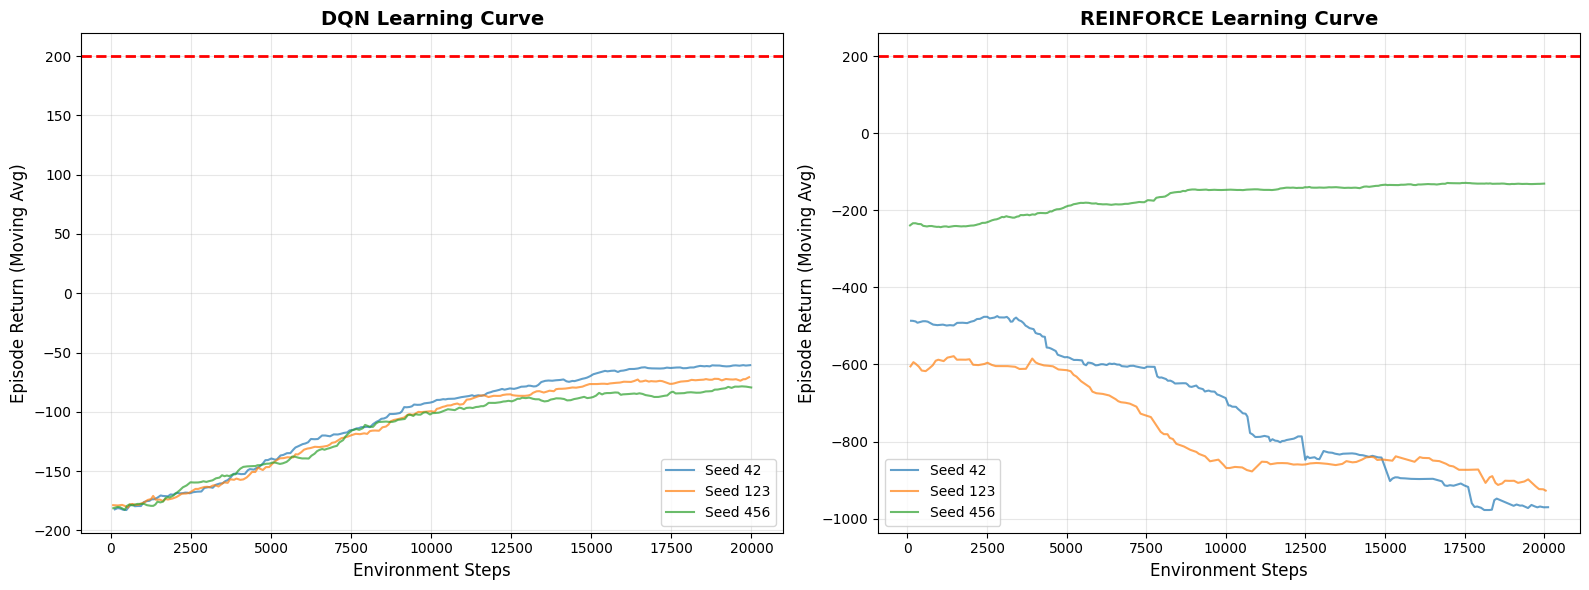


Analysis Report

COMPARISON REPORT: DQN vs REINFORCE

1. FINAL PERFORMANCE (last 100 episodes)
------------------------------------------------------------
DQN:
  Mean Return: -77.98 ± 7.29
  Seeds Solved: 0/3

REINFORCE:
  Mean Return: -607.58 ± 336.04
  Seeds Solved: 0/3

Winner: DQN

2. SAMPLE EFFICIENCY (steps to reach 200 reward)
------------------------------------------------------------
DQN:
  Mean Steps: N/A (not reached)

REINFORCE:
  Mean Steps: N/A (not reached)

More Efficient: Neither (both didn't reach threshold)

3. STABILITY
------------------------------------------------------------
DQN Variance: 7.29
REINFORCE Variance: 336.04

More Stable: DQN


✓ Report saved to 'comparison_report.txt'

✓ Training complete! All results saved.


In [23]:
device = check_gpu()
print('='*60)
print('Training DQN')
print('='*60)
dqn_results = []
for seed in GLOBAL_CONFIG['seeds']:
    set_seed(seed)
    env = create_env(seed)
    agent = DQNAgent(8, 4, {**GLOBAL_CONFIG, **DQN_CONFIG}, device=device)
    results = train_dqn(env, agent, {**GLOBAL_CONFIG, **DQN_CONFIG}, seed)
    dqn_results.append(results)
    env.close()

    # Save DQN checkpoints per seed if enabled
    if GLOBAL_CONFIG.get('save_checkpoint'):
        os.makedirs('checkpoints', exist_ok=True)
        try:
            torch.save(agent.q_network.state_dict(), f"checkpoints/dqn_seed{seed}_qnet.pt")
            torch.save(agent.target_network.state_dict(), f"checkpoints/dqn_seed{seed}_target.pt")
            print(f"✓ DQN checkpoints saved for seed {seed} -> checkpoints/dqn_seed{seed}_*.pt")
        except Exception as e:
            print(f"⚠ Could not save DQN checkpoint for seed {seed}: {e}")

# Clear GPU cache between seeds
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print('\n' + '='*60)
print('Training REINFORCE')
print('='*60)
reinforce_results = []
for seed in GLOBAL_CONFIG['seeds']:
    set_seed(seed)
    env = create_env(seed)
    agent = REINFORCEAgent(8, 4, {**GLOBAL_CONFIG, **REINFORCE_CONFIG}, device=device)
    results = train_reinforce(env, agent, {**GLOBAL_CONFIG, **REINFORCE_CONFIG}, seed)
    reinforce_results.append(results)
    env.close()

    # Save REINFORCE checkpoints per seed if enabled
    if GLOBAL_CONFIG.get('save_checkpoint'):
        os.makedirs('checkpoints', exist_ok=True)
        try:
            torch.save(agent.policy.state_dict(), f"checkpoints/reinforce_seed{seed}_policy.pt")
            if hasattr(agent, 'value_net') and agent.value_net is not None:
                torch.save(agent.value_net.state_dict(), f"checkpoints/reinforce_seed{seed}_value.pt")
            print(f"✓ REINFORCE checkpoints saved for seed {seed} -> checkpoints/reinforce_seed{seed}_*.pt")
        except Exception as e:
            print(f"⚠ Could not save REINFORCE checkpoint for seed {seed}: {e}")

    # Clear GPU cache between seeds
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Save results
print('\n' + '='*60)
print('Saving Results')
print('='*60)

with open('dqn_results.json', 'w') as f:
    json.dump(dqn_results, f, indent=2)
print("✓ DQN results saved to 'dqn_results.json'")

with open('reinforce_results.json', 'w') as f:
    json.dump(reinforce_results, f, indent=2)
print("✓ REINFORCE results saved to 'reinforce_results.json'")

# Generate plots
print('\n' + '='*60)
print('Generating Visualizations')
print('='*60)
try:
    plot_learning_curves(dqn_results, reinforce_results)
except Exception as e:
    print(f"⚠ Could not generate plots: {e}")

# Generate report
print('\n' + '='*60)
print('Analysis Report')
print('='*60)
report = generate_report(dqn_results, reinforce_results)
print(report)

# Save report
with open('comparison_report.txt', 'w') as f:
    f.write(report)
print("✓ Report saved to 'comparison_report.txt'")

print('\n' + '='*60)
print('✓ Training complete! All results saved.')
print('='*60)

#### Core code required for assignment is completed in above.
below is for more extended learning to check how the implementation comares with SB3 RL algo

In [24]:
!pip install -q stable-baselines3[extra] sb3-contrib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 19.8 MB/s eta 0:00:00


In [25]:
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [26]:
def make_sb3_env(seed: int):
    # Create env and wrap with Monitor; sb3 expects envs to return reward/ep stats via Monitor
    e = create_env(seed)
    e = Monitor(e)
    return e


def _train_sb3_model(AlgorithmClass, seeds, global_config, alg_config, name_prefix):
    results = []
    for seed in seeds:
        set_seed(seed)
        env = DummyVecEnv([lambda: make_sb3_env(seed)])
        eval_env = DummyVecEnv([lambda: make_sb3_env(seed+1000)])

        policy_kwargs = dict(net_arch=alg_config['hidden_layers'])

        # Build algorithm-specific params
        alg_kwargs = {}
        if AlgorithmClass is DQN:
            alg_kwargs = dict(
                learning_rate=alg_config.get('learning_rate', 5e-4),
                buffer_size=alg_config.get('buffer_capacity', 100_000),
                learning_starts=alg_config.get('prefill_steps', 1000),
                batch_size=alg_config.get('batch_size', 64),
                policy_kwargs=policy_kwargs,
                verbose=0,
            )
        else:
            alg_kwargs = dict(
                learning_rate=alg_config.get('learning_rate', 3e-4),
                policy_kwargs=policy_kwargs,
                verbose=0,
            )

        model = AlgorithmClass('MlpPolicy', env, **alg_kwargs)

        eval_steps = []
        eval_returns = []
        steps_trained = 0
        while steps_trained < global_config['total_steps']:
            steps_to_run = min(global_config['eval_frequency'], global_config['total_steps'] - steps_trained)
            model.learn(total_timesteps=steps_to_run, reset_num_timesteps=False)
            steps_trained += steps_to_run
            avg_ret, std_ret = evaluate_policy(model, eval_env, n_eval_episodes=global_config.get('eval_episodes', 10), deterministic=True)
            eval_steps.append(steps_trained)
            eval_returns.append(avg_ret)
            print(f"{name_prefix} seed={seed} trained={steps_trained} eval_avg={avg_ret:.2f}")

        # Save model
        os.makedirs('checkpoints', exist_ok=True)
        model.save(f"checkpoints/{name_prefix}_seed{seed}.zip")

        results.append({'seed': seed, 'episode_steps': eval_steps, 'episode_returns': eval_returns})

        env.close()
        eval_env.close()

    return results


# Small helper wrappers for DQN and (PPO used as a proxy for REINFORCE)
def train_sb3_dqn(seeds, global_config, dqn_config):
    return _train_sb3_model(DQN, seeds, global_config, dqn_config, 'sb3_dqn')


def train_sb3_ppo(seeds, global_config, ppo_config):
    return _train_sb3_model(PPO, seeds, global_config, ppo_config, 'sb3_ppo')


Training SB3 DQN
sb3_dqn seed=42 trained=10000 eval_avg=-108.16
sb3_dqn seed=42 trained=20000 eval_avg=-83.42
sb3_dqn seed=123 trained=10000 eval_avg=-49.36
sb3_dqn seed=123 trained=20000 eval_avg=-159.68
sb3_dqn seed=456 trained=10000 eval_avg=2.01
sb3_dqn seed=456 trained=20000 eval_avg=-30.04

Training SB3 PPO (policy-gradient proxy for REINFORCE)


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


sb3_ppo seed=42 trained=10000 eval_avg=-425.76
sb3_ppo seed=42 trained=20000 eval_avg=-103.79
sb3_ppo seed=123 trained=10000 eval_avg=31.58
sb3_ppo seed=123 trained=20000 eval_avg=-32.76
sb3_ppo seed=456 trained=10000 eval_avg=-204.92
sb3_ppo seed=456 trained=20000 eval_avg=-42.77
✓ SB3 DQN results saved to sb3_dqn_results.json
✓ SB3 PPO results saved to sb3_ppo_results.json
--- FINAL PERFORMANCE STATS ---
Custom DQN: {'final_return_mean': np.float64(-77.98232538805937), 'final_return_std': np.float64(7.286361799488036), 'steps_to_threshold_mean': inf, 'steps_to_threshold_std': 0.0, 'solved_seeds': 0, 'total_seeds': 3}
SB3 DQN:   {'final_return_mean': np.float64(-71.4425591), 'final_return_std': np.float64(40.76062876338832), 'steps_to_threshold_mean': inf, 'steps_to_threshold_std': 0.0, 'solved_seeds': 0, 'total_seeds': 3}
Custom REINFORCE: {'final_return_mean': np.float64(-607.5800319075041), 'final_return_std': np.float64(336.0378667885159), 'steps_to_threshold_mean': inf, 'steps_to

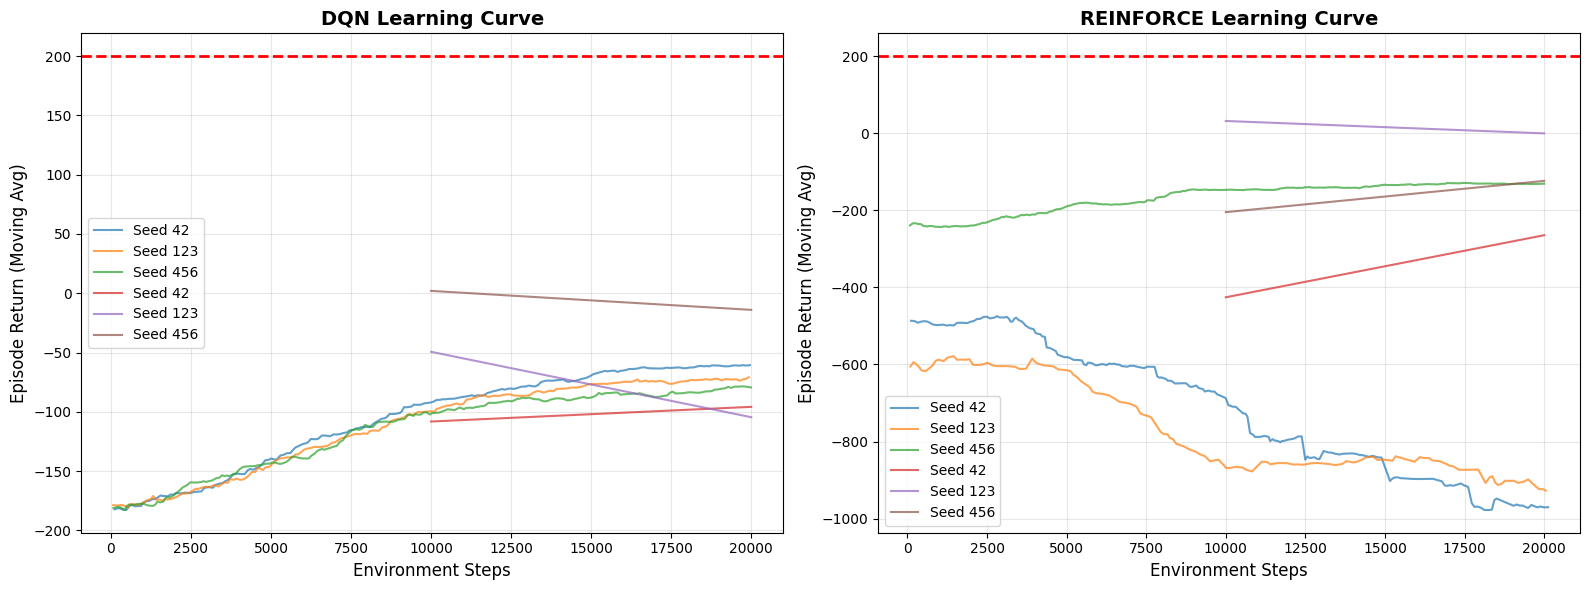

In [27]:
# Run SB3 experiments (DQN + PPO)
print('='*60)
print('Training SB3 DQN')
print('='*60)
sb3_dqn_results = train_sb3_dqn(GLOBAL_CONFIG['seeds'], GLOBAL_CONFIG, DQN_CONFIG)

print('\n' + '='*60)
print('Training SB3 PPO (policy-gradient proxy for REINFORCE)')
print('='*60)
sb3_ppo_results = train_sb3_ppo(GLOBAL_CONFIG['seeds'], GLOBAL_CONFIG, REINFORCE_CONFIG)

# Save SB3 results
with open('sb3_dqn_results.json', 'w') as f:
    json.dump(sb3_dqn_results, f, indent=2)
print('✓ SB3 DQN results saved to sb3_dqn_results.json')

with open('sb3_ppo_results.json', 'w') as f:
    json.dump(sb3_ppo_results, f, indent=2)
print('✓ SB3 PPO results saved to sb3_ppo_results.json')

# Map SB3 results into same format used by plotting/compute stats
sb3_dqn_results_mapped = [{'seed': r['seed'], 'episode_steps': r['episode_steps'], 'episode_returns': r['episode_returns']} for r in sb3_dqn_results]
sb3_ppo_results_mapped = [{'seed': r['seed'], 'episode_steps': r['episode_steps'], 'episode_returns': r['episode_returns']} for r in sb3_ppo_results]

# Compute stats for all 4 series
custom_dqn_stats = compute_statistics(dqn_results)
sb3_dqn_stats = compute_statistics(sb3_dqn_results_mapped)
custom_reinforce_stats = compute_statistics(reinforce_results)
sb3_ppo_stats = compute_statistics(sb3_ppo_results_mapped)

print('--- FINAL PERFORMANCE STATS ---')
print('Custom DQN:', custom_dqn_stats)
print('SB3 DQN:  ', sb3_dqn_stats)
print('Custom REINFORCE:', custom_reinforce_stats)
print('SB3 PPO (REINFORCE proxy):', sb3_ppo_stats)

# Add combined plots: DQN (custom vs SB3) and REINFORCE vs PPO
print('\n'+ '='*60)
print('Plotting comparison curves')
print('='*60)
plot_learning_curves(dqn_results + sb3_dqn_results_mapped, reinforce_results + sb3_ppo_results_mapped)

In [28]:
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [29]:
custom_dqn_results = dqn_results if 'dqn_results' in globals() else []
custom_reinforce_results = reinforce_results if 'reinforce_results' in globals() else []
sb3_dqn_results = sb3_dqn_results_mapped if 'sb3_dqn_results_mapped' in globals() else []
sb3_ppo_results = sb3_ppo_results_mapped if 'sb3_ppo_results_mapped' in globals() else []

# Compute stats using the notebook's compute_statistics helper
custom_dqn_stats = compute_statistics(custom_dqn_results)
custom_reinforce_stats = compute_statistics(custom_reinforce_results)
sb3_dqn_stats = compute_statistics(sb3_dqn_results)
sb3_ppo_stats = compute_statistics(sb3_ppo_results)

# Build a DataFrame summarizing key metrics
rows = []
rows.append({
    'Model': 'DQN',
    'Implementation': 'Custom',
    'FinalReturnMean': custom_dqn_stats['final_return_mean'],
    'FinalReturnStd': custom_dqn_stats['final_return_std'],
    'StepsToThresholdMean': custom_dqn_stats['steps_to_threshold_mean'] if custom_dqn_stats['steps_to_threshold_mean'] != float('inf') else None,
    'StepsToThresholdStd': custom_dqn_stats['steps_to_threshold_std'] if custom_dqn_stats['steps_to_threshold_std'] > 0 else 0.0,
    'SolvedSeeds': custom_dqn_stats['solved_seeds'],
    'TotalSeeds': custom_dqn_stats['total_seeds'],
})
rows.append({
    'Model': 'DQN',
    'Implementation': 'SB3',
    'FinalReturnMean': sb3_dqn_stats['final_return_mean'],
    'FinalReturnStd': sb3_dqn_stats['final_return_std'],
    'StepsToThresholdMean': sb3_dqn_stats['steps_to_threshold_mean'] if sb3_dqn_stats['steps_to_threshold_mean'] != float('inf') else None,
    'StepsToThresholdStd': sb3_dqn_stats['steps_to_threshold_std'] if sb3_dqn_stats['steps_to_threshold_std'] > 0 else 0.0,
    'SolvedSeeds': sb3_dqn_stats['solved_seeds'],
    'TotalSeeds': sb3_dqn_stats['total_seeds'],
})
rows.append({
    'Model': 'REINFORCE',
    'Implementation': 'Custom',
    'FinalReturnMean': custom_reinforce_stats['final_return_mean'],
    'FinalReturnStd': custom_reinforce_stats['final_return_std'],
    'StepsToThresholdMean': custom_reinforce_stats['steps_to_threshold_mean'] if custom_reinforce_stats['steps_to_threshold_mean'] != float('inf') else None,
    'StepsToThresholdStd': custom_reinforce_stats['steps_to_threshold_std'] if custom_reinforce_stats['steps_to_threshold_std'] > 0 else 0.0,
    'SolvedSeeds': custom_reinforce_stats['solved_seeds'],
    'TotalSeeds': custom_reinforce_stats['total_seeds'],
})
rows.append({
    'Model': 'PPO',
    'Implementation': 'SB3',
    'FinalReturnMean': sb3_ppo_stats['final_return_mean'],
    'FinalReturnStd': sb3_ppo_stats['final_return_std'],
    'StepsToThresholdMean': sb3_ppo_stats['steps_to_threshold_mean'] if sb3_ppo_stats['steps_to_threshold_mean'] != float('inf') else None,
    'StepsToThresholdStd': sb3_ppo_stats['steps_to_threshold_std'] if sb3_ppo_stats['steps_to_threshold_std'] > 0 else 0.0,
    'SolvedSeeds': sb3_ppo_stats['solved_seeds'],
    'TotalSeeds': sb3_ppo_stats['total_seeds'],
})

summary_df = pd.DataFrame(rows)
# Format nicely
summary_df['FinalReturnMean'] = summary_df['FinalReturnMean'].round(2)
summary_df['FinalReturnStd'] = summary_df['FinalReturnStd'].round(2)
summary_df['StepsToThresholdMean'] = summary_df['StepsToThresholdMean'].apply(lambda x: int(x) if x is not None else None)
summary_df['StepsToThresholdStd'] = summary_df['StepsToThresholdStd'].round(0)

print('Summary table for custom vs SB3 models:')
display(summary_df)

Summary table for custom vs SB3 models:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,Model,Implementation,FinalReturnMean,FinalReturnStd,StepsToThresholdMean,StepsToThresholdStd,SolvedSeeds,TotalSeeds
0,DQN,Custom,-77.98,7.29,None,0.0,0,3
1,DQN,SB3,-71.44,40.76,None,0.0,0,3
2,REINFORCE,Custom,-607.58,336.04,None,0.0,0,3
3,PPO,SB3,-129.74,107.93,None,0.0,0,3


✓ Comparison plot saved as comparison_table_plot.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


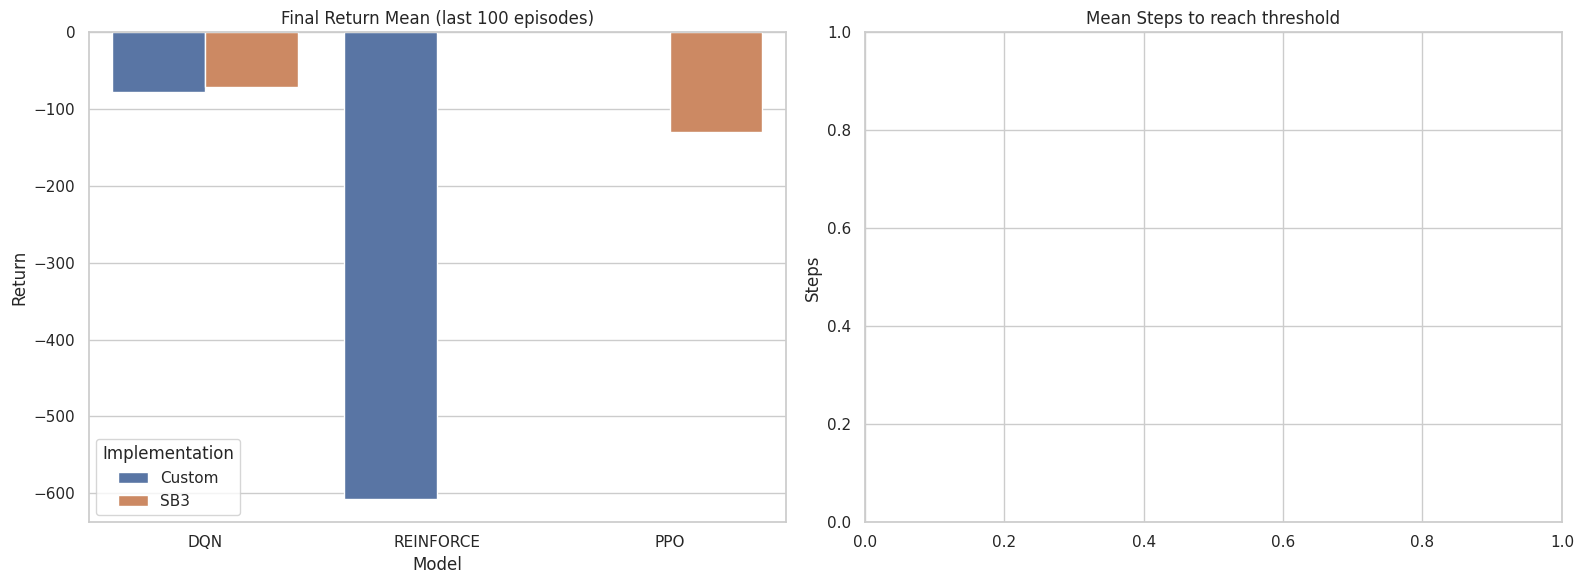

In [30]:
# Visual comparison plot for final return and steps-to-threshold
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Final Return mean + std (bar plot with error bars)
groups = summary_df.groupby(['Model', 'Implementation']).mean().reset_index()

ax = axes[0]
sns.barplot(data=summary_df, x='Model', y='FinalReturnMean', hue='Implementation', ax=ax, capsize=0.1)
# Add error bars
for i, row in summary_df.iterrows():
    x = 0 if row['Model'] == 'DQN' else 1 if row['Model'] == 'REINFORCE' else 2
    # We'll let seaborn place bars automatically; use bar containers for more accurate anchors if desired

ax.set_title('Final Return Mean (last 100 episodes)')
ax.set_ylabel('Return')

# Panel 2: Steps to threshold (bar plot). show N/A as missing bars
ax = axes[1]
plot_df = summary_df.copy()
plot_df = plot_df[plot_df['StepsToThresholdMean'].notna()]
sns.barplot(data=plot_df, x='Model', y='StepsToThresholdMean', hue='Implementation', ax=ax, capsize=0.1)
ax.set_title('Mean Steps to reach threshold')
ax.set_ylabel('Steps')

plt.tight_layout()
plt.savefig('comparison_table_plot.png', dpi=300, bbox_inches='tight')
print('✓ Comparison plot saved as comparison_table_plot.png')
plt.show()

In [31]:
# Notes & interpretation
print('Notes:')
print('- "FinalReturnMean": mean of the last window (by default 100 episodes)')
print('- "StepsToThresholdMean": mean number of environment steps to reach threshold (200 reward), N/A if not reached')
print('- SB3 PPO is used as a proxy for REINFORCE, not an exact match')
print('- Where SB3 doesn\'t produce per-episode arrays with 100+ points, StepsToThreshold may be N/A')

# Also print a quick RANKING of final mean returns
rank_df = summary_df.sort_values(['FinalReturnMean'], ascending=False)
print('\nModel ranking by FinalReturnMean (higher is better):')
display(rank_df[['Model','Implementation','FinalReturnMean','FinalReturnStd']])

Notes:
- "FinalReturnMean": mean of the last window (by default 100 episodes)
- "StepsToThresholdMean": mean number of environment steps to reach threshold (200 reward), N/A if not reached
- SB3 PPO is used as a proxy for REINFORCE, not an exact match
- Where SB3 doesn't produce per-episode arrays with 100+ points, StepsToThreshold may be N/A

Model ranking by FinalReturnMean (higher is better):


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,Model,Implementation,FinalReturnMean,FinalReturnStd
1,DQN,SB3,-71.44,40.76
0,DQN,Custom,-77.98,7.29
3,PPO,SB3,-129.74,107.93
2,REINFORCE,Custom,-607.58,336.04


Based on earlier resutls the DQN  implementation is at par with SB3 library.

Where as the wrapper we created on top of SB3 (PPO) to mimic REINFORCE didnt yeild good results.
Need to explore more on this.